# Evaluating Machine Learning Classification Models and Sampling for Classification

Once we have some classification models trained to predict our target variable, we
need a way to compare them and choose the best one. One way to compare models
is to use metrics such as accuracy and others. In classification, we can often find
that our classes or targets are imbalanced. We can improve the performance of ML
classification algorithms by means of sampling techniques, such as oversampling
and undersampling.

## Evaluating classification algorithm performance with metrics

### Train-validation-test splits

When evaluating the performance of an algorithm, it's important to look at
performance on data that was not used for training. The model has already learned all
the ins and outs of the training data, and may have even overfit to the training data,
learning patterns related to noise in the data. Instead, we want to evaluate performance
on a hold-out set, which we may call a validation or test set.

> For some algorithms, such
as neural networks, we train the model on a training set, monitor performance during
training on a validation set, and then evaluate final performance on a test set.

For most
other ML algorithms, we simply use a training and test set If our test or validation
sets contain information from the training data, this is called data leakage. Data
leakage leads to high validation or tests scores which are not representative of the true
performance of our model. It's like having the answers before a test and scoring well,
even though you don't really know the material on the test.

In [1]:
import pandas as pd


df = pd.read_excel("data/default of credit card clients.xls", skiprows=1, index_col=0)

target_col = "default payment next month"

features = df.drop(target_col, axis=1)

targets = df[target_col]

In [2]:
# Now, split the dataset into testing and training sets with sklearn

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, targets, train_size = 0.75, stratify = targets)

> The model_selection module from sklearn contains the train_test_split function,
which takes arguments of features, targets, and more. With binary or multi-class
classification, it's always a good idea to use the stratify argument with our class
labels so that the proportion of classes stays the same across the training and test
sets. This ensures that we don't have biases due to class imbalances between training
and test sets. We also choose a training size of 75% of the data here, which is typical.
Somewhere between 60% and 90% of the data used as the training set is common.

In [3]:
# Fit model to the training data
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)

lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

### Accuracy

One of the simplest classification metrics is accuracy, and is the default for most (if
not all) sklearn score() methods for classifiers

In [4]:
print(lr_model.score(x_train, y_train))

0.7787555555555555


In [5]:
print(lr_model.score(x_test, y_test))

0.7788


This shows that both accuracies are around 78% (or 0.78 as returned from the score
function). Since the training and test scores are quite similar, we don't see evidence of
overfitting to the data. If the train score was much higher (for example, 90% accuracy
on training and 60% accuracy on test), we should be concerned that our model is
likely overfitting to the data. We should then use strategies to reduce overfitting,
such as feature selection and pruning, regularization, or using a simpler model.

The accuracy value seems high, but we should compare it to the "no information
rate." This is the accuracy we could expect with no information about the target
(no features). We can approximate this with the majority class fraction, and our
"no information" model could guess that all samples are this majority class. We
can calculate the class fractions like so:

In [6]:
df["default payment next month"].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

This shows us that the majority class (0, no default) composes around 78% of the
data, so our model is no better than guessing the majority class for every prediction.
We could also find this result using sklearn.dummy.DummyClassifier (using the
strategy='most_frequent' argument).

Another way to estimate the performance of a classifier is cross-validation, as we
discussed earlier. We can get a more reliable accuracy score using cross-validation.
First, we need to load the classification models we used in the previous chapter,
as well as create our scaled (standardized) features:

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


gnb = GaussianNB()
lr_cv = LogisticRegressionCV(max_iter=1000)
lr_cv.fit(features, targets)
lr_best_c = LogisticRegression(C=lr_cv.C_[0])
knn = KNeighborsClassifier()

In [8]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(gnb, features, targets, n_jobs = -1, cv = 10).mean())
print(cross_val_score(lr_best_c, features, targets, n_jobs = -1, cv = 10).mean())
print(cross_val_score(knn, features, targets, n_jobs = -1, cv = 10).mean())
print(cross_val_score(knn, scaled_features, targets, n_jobs = -1, cv = 10).mean())

0.3779666666666667
0.7787333333333333
0.7556999999999999
0.7926666666666666


The drawback of cross-validation is that it trains and evaluates several models
(5 with the default settings), so is slower to run than a single training/test split.
However, it gives us a more robust measure of the performance of the algorithms.
cross_val_score also uses stratified training/validation splits by default, so we
don't need to worry about class imbalances in the training and validation sets. In the
preceding code, we import the cross_val_score function from sklearn, and then use
it with our models we created in the previous sections. The cross_val_score function
returns a NumPy array of scores on the validation sets with 5-fold cross-validation
(so we have a 5-element NumPy array, although this can be changed with the cv
argument). We then take the average of this with mean(). We try it with the Naïve
Bayes model, our logistic regression model with the C hyperparameter optimized,
and KNN with the scaled and unscaled features.


We can see that the KNN model on scaled features performs best. We also see that
scaling also improves the performance of the KNN model (79.2% accuracy versus
75.5% with unscaled data). If we train these models and evaluate them on the same
training data, the scores on the training data alone were a little different (usually
better) than these cross-validation scores. It's always best to evaluate metrics on
a validation or test set or to use cross-validation to get an accurate reading in terms
of which model is best.

#### Cohen's Kappa

Although we can compare accuracy to the "no information" rate, one way to
automatically incorporate this into an accuracy-like metric is Cohen's Kappa. This
metric takes into account a random model and gives us a value between -1 and +1.
A value of 0 means that our model is no better than random guessing. A value of
1 means we have perfect accuracy, while negative values mean we have a model
that's worse than random guessing (or using a "no information" model, such as
guessing the majority class for every prediction). Cohen's Kappa does, however,
have a drawback where it tends to return lower values when our classes are more
imbalanced. But it can still be useful for comparing models without having to
consider the no information rate.

In [9]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_test, lr_model.predict(x_test))

0.0

In [10]:
from sklearn.metrics import make_scorer

print(cross_val_score(lr_model, features, targets, scoring=make_scorer(cohen_kappa_score), n_jobs=-1).mean())

-6.663869982279636e-05


> We provide the scoring argument and need to use the make_scorer function to
convert the metric to a scoring function. Again, the result here is a Cohen's Kappa
score near 0.

#### Confusion Matrix

Another common set of metrics for classification can be examined with a confusion
matrix. A confusion matrix contains a table of metric values with rows as actual
values and columns as predicted values.

For binary classification, this contains true
positives (TP, where predictions for positive cases, or values of 1, were correct),
true negatives (TN, correct negative cases), false positives (FP, where predictions
for negative cases were 1 but should've been 0), and false negatives (FN, where
the prediction was 0 but should've been 1).

C:\Users\INNO\Anaconda3\envs\practical_data_science_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


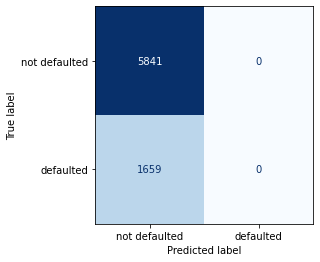

In [11]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(lr_model, x_test, y_test, cmap=plt.cm.Blues,
                     display_labels=["not defaulted", "defaulted"],
                      colorbar = False)

We import the plot_confusion_matrix function and set several arguments for it.
We first provide the model, followed by the features and targets (using the test set),
and then change some options for aesthetics. We change the colormap to a set of
blue colors (which is better than the default colors), provide labels for the targets
and predictions on the plot with display_labels, and turn off the colorbar since it is
extraneous (the values are already printed on the cells).

Right away, we can see we have a problem – we haven't got any true positives (the
value of 0 in the bottom right of the confusion matrix) or positive predictions at all.
Our model is having trouble with predicting defaults based on our data.

The confusion matrix can also be used for multi-class classification. First, we need to
create our multi-label features and targets and fit the logistic regression model to the
data:

In [12]:
pay_0_target = df['PAY_0'].replace({i: 1 for i in range(1, 9)})
pay_0_features = df.drop(['PAY_0', 'default payment next month'],
axis=1)
lr_multi = LogisticRegression(max_iter=1000)
lr_multi.fit(pay_0_features, pay_0_target)

C:\Users\INNO\Anaconda3\envs\practical_data_science_env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

> Here, we are predicting the multi-class PAY_0 column after replacing all the values
greater than 0 with 1 (which are late payments) – this has 4 unique classes. Then,
we can plot our confusion matrix:

In [13]:
pay_0_target.value_counts()

 0    14737
 1     6818
-1     5686
-2     2759
Name: PAY_0, dtype: int64

C:\Users\INNO\Anaconda3\envs\practical_data_science_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


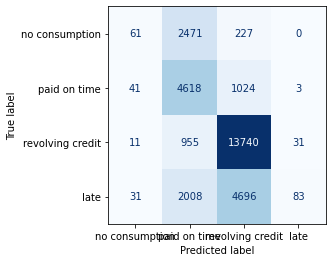

In [14]:
plot_confusion_matrix(lr_multi,
                    pay_0_features,
                    pay_0_target,
                    display_labels=['no consumption', 'paid on time', 'revolving credit','late'],
                    cmap=plt.cm.Blues,
                    colorbar=False)

Confusion matrices from our multi-class, multilabel
problem, where we predicted the values of 0 or 1 for each of the PAY_i

In [16]:
import swifter

pay_cols = ["PAY_0"] + [f"PAY_{i}" for i in range(2, 7)]
                        
mo_targets = df[pay_cols].copy()

mo_targets = mo_targets.swifter.apply(lambda x: (x > 0).astype(int), axis = 1)

mo_features = df[[col for col in df.columns if col not in pay_cols + ["default payment next month"]]]


from sklearn.multioutput import MultiOutputClassifier

mo_clf = MultiOutputClassifier(LogisticRegression(max_iter=1000), n_jobs = -1)
mo_clf.fit(mo_features, mo_targets)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000), n_jobs=-1)

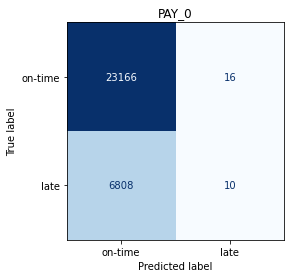

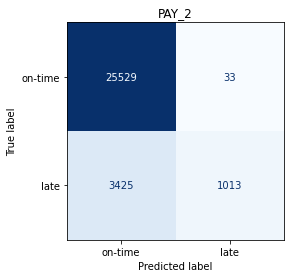

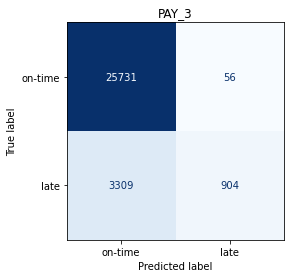

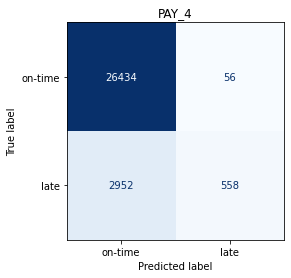

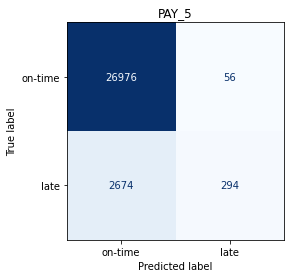

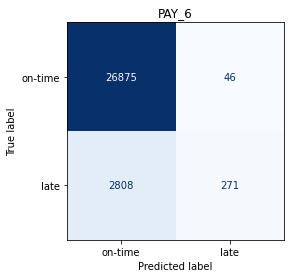

In [20]:
# Get the Confusion Matrices

from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

ml_cm = multilabel_confusion_matrix(mo_targets, mo_clf.predict(mo_features))


for i, cl in enumerate(mo_targets.columns):
    f = ConfusionMatrixDisplay(ml_cm[i], display_labels=["on-time", "late"])
    f.plot(cmap=plt.cm.Blues, colorbar=False)
    plt.title(cl)
    plt.grid(visible=False)

> We first get all the confusion matrices with the multilabel_confusion_matrix
function, which takes the same arguments as the confusion_matrix function. Then
we loop through our class names from our mo_targets data frame, and use the
enumerate() built-in function. This function returns a tuple of a counter (starting
at 0 by default) and our object (each mo_target column name).

> We use this index (i) to get the confusion matrix for each class and plot it with the
ConfusionMatrixDisplay function. This function does not require a model and only
needs the confusion matrix, which suits our purposes here. We provide the display
labels to this function as well. It returns an object which has a plot method, where
we can change the color and remove the colorbar. Finally, we set the title as the class
name (cl) and turn off the gridlines

### Precision, Recall, and F1 Score

Closely related to TP, FP, FN, and TN from the confusion matrix are precision, recall,
and the F1 score. `Precision can be thought of as the correctly predicted positives
divided by all the predicted positives. This is TP / (TP + FP).` `Recall can be thought of
as the correctly predicted positives divided by all the actual positives, which is TP /
(TP + FN).` As you can see, the one thing directly missing from precision and recall is
the true negative values.

The F1 score is the harmonic mean of these two measures, which is:
`2 * Precision * Recall / (Precision + Recall)`

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, lr_model.predict(x_test), target_names=["no default", "default"]))

              precision    recall  f1-score   support

  no default       0.78      1.00      0.88      5841
     default       0.00      0.00      0.00      1659

    accuracy                           0.78      7500
   macro avg       0.39      0.50      0.44      7500
weighted avg       0.61      0.78      0.68      7500



C:\Users\INNO\Anaconda3\envs\practical_data_science_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\INNO\Anaconda3\envs\practical_data_science_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\INNO\Anaconda3\envs\practical_data_science_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

> It's important to print the report since the resulting string has some formatting,
such as newlines. The function takes the true target values first and predicted values
second. We also set the class names in the report with the target_names argument.

We can see that the precision, recall, and F1 score are present for each unique
class. We also have support, which is the number of samples in the dataset we are
evaluating for each row. The overall accuracy is shown, as well as a macro-weighted
average. The macro average is unweighted, meaning all classes are treated equally
(it's the simple average of the precision values, for example). The weighted average
is sometimes called the micro average and aggregates the TP and other values to
calculate the precision, recall, and F1 scores.

C:\Users\INNO\Anaconda3\envs\practical_data_science_env\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
C:\Users\INNO\Anaconda3\envs\practical_data_science_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


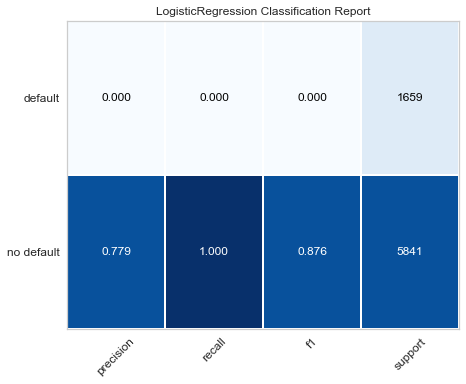

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [23]:
from yellowbrick.classifier import ClassificationReport

f, ax = plt.subplots(1,1)

viz = ClassificationReport(lr_model,
                          support = True,
                          classes = ["no default", "default"],
                           cmap = "Blues"
                          )


viz.score(x_test, y_test)
plt.gcf().delaxes(f.axes[1])
viz.show()

First, we import the ClassificationReport function from yellowbrick, and then give
this function our model and a few arguments. We tell the function to include the
support with support=True (the number of samples from our evaluation), we give
it labels for the classes with the classes argument, and change the colormap to be
shades of blue. Then we use the score method of the returned object (viz.score())
on our test data.

> We can see that it's the same information as the sklearn report, minus the accuracy,
as well as macro and micro averages. Of course, this easily extends to multi-class
models (single-label, not multi-label). For example, with sklearn, we can do this:

In [24]:
print(classification_report(pay_0_target, lr_multi.predict(pay_0_features), target_names = [
    "no consumtion", "on time", "credit", "late"
]))

               precision    recall  f1-score   support

no consumtion       0.42      0.02      0.04      2759
      on time       0.46      0.81      0.59      5686
       credit       0.70      0.93      0.80     14737
         late       0.71      0.01      0.02      6818

     accuracy                           0.62     30000
    macro avg       0.57      0.44      0.36     30000
 weighted avg       0.63      0.62      0.51     30000



### AUC Score and the ROC Curve

Another useful metric for classification is the area under the curve score (AUC) from
the receiver operating characteristic (ROC) curve. To get the AUC, we first calculate
the ROC, and can plot it as follows:

C:\Users\INNO\Anaconda3\envs\practical_data_science_env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


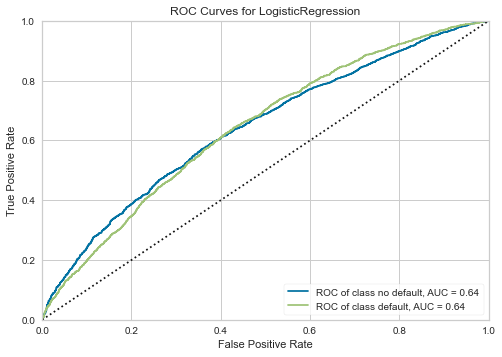

In [25]:
from yellowbrick.classifier.rocauc import roc_auc

roc = roc_auc(lr_model, x_train, y_train, x_test, y_test, classes = ["no default", "default"], macro = False, micro = False)

The yellowbrick package provides a convenient way to do this, although there is
a function in sklearn that can do the same thing (sklearn.metrics.plot_roc_curve).
The advantage of yellowbrick is that it can plot multiple
classes whereas sklearn cannot. For example

C:\Users\INNO\Anaconda3\envs\practical_data_science_env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


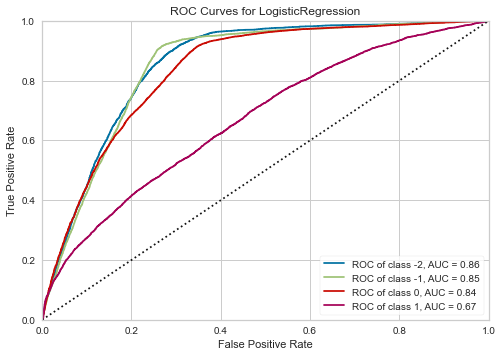

In [26]:

roc = roc_auc(lr_multi, pay_0_features, pay_0_target, macro = False, micro = False)

To plot ROC curves from our multi-class, single-label classification problem. In our
above example here, we simply use the roc_auc function from yellowbrick similarly
to the classification report, giving it our model, x and y values for training and test
sets, and a list of class names for better labeling. We also turn off the macro and
micro averages since these don't make much sense for ROC curves and AUC.

C:\Users\INNO\Anaconda3\envs\practical_data_science_env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


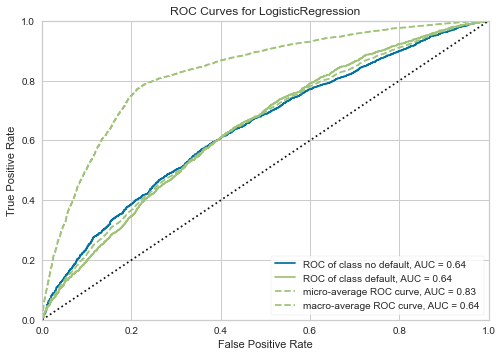

In [27]:
roc = roc_auc(lr_model, x_train, y_train, x_test, y_test, classes = ["no default", "default"])

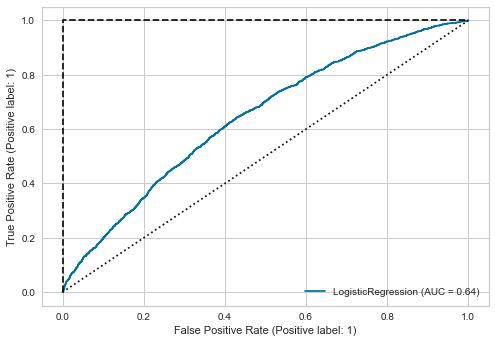

In [28]:
from sklearn.metrics import plot_roc_curve

roc = plot_roc_curve(lr_model, x_test, y_test)

plt.plot([0, 1], [0, 1], c = "k", linestyle="dotted", label = "random model")

plt.plot([0, 0, 1],
         [0, 1, 1],
         c = "k",
         linestyle = "dashed",
         label = "perfect model"
        )

We first import the sklearn plot_roc_curve function and give it our model, x, and y
data. We also plot a diagonal dashed line with a black color (c='k'), which represents
a random-guessing or "no information" model, and call plt.legend() so that all our
labels show up. Finally, we plot a dashed line that represents a perfectly accurate
model passing through the upper left of the plot.

> We can see this is much simpler and easier to interpret than the default yellowbrick
ROC curve plot. The plot shows the false positive rate (FPR) on the x axis, which is
FP / (FP + TN). The y axis has the true positive rate (TPR), which is TP / (TP + FN).
We can see that the ROC curve is to the left and above the dashed line, which means
we are doing better than random guessing. We also see that the area under the curve
(AUC) score in the bottom right is 0.65, which is the integral (sum) of the area under
the ROC curve. We can get this metric with roc.roc_auc from the returned object
from plot_roc_curve(). A perfect model with 100% accuracy would have an AUC
score of 1, and the ROC curve creates the dashed line that goes through the upper
left of the plot shown in the preceding figure.

> The AUC score gives us a way to compare models that takes into account all the
different rounding thresholds for our probability predictions that we may use. Since
most models can produce a probability estimate for each class, we can choose what
the rounding threshold is for rounding up or down. When we have a rounding
threshold of 1 or higher, so that all predictions are rounded down to 0, we have no
FP and no TP, and we are at the bottom left of the ROC curve. On the other hand,
a threshold of 0 means all cases are predicted as positive (1), and we have an FPR
of 1 and a TPR of 1 (the upper right of the plot). All other thresholds are in between
and form the ROC curve. There are a few different methods for choosing the optimal
threshold, and some involve the ROC curve.

### Choosing the Optimal Cut-Off Threshold

By default, our threshold for rounding is 0.5 – any probability prediction greater than
0.5 is rounded up to 1, otherwise we round down to 0. We can change this threshold
to optimize different metrics. For example, we can maximize the F1 score, giving us
a balance between precision and recall, or we can manually change the threshold to
achieve a desired precision, recall, or other metric value. A few ways we'll look at
here are as follows:
- Youden's J (maximum TPR - FPR)
- Upper-left distance (minimum distance from ROC curve to the point [0,1]
- F1 maximum

These three approaches are slightly different. Youden's J maximizes the
"discrimination" of the model between true positives and false positives, while the
upper-left method maximizes the TPR while maintaining a good FPR, and the F1
score balances precision and recall.

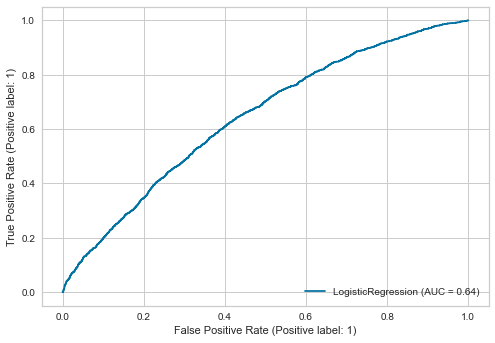

In [29]:
import numpy as np

roc = plot_roc_curve(lr_model, x_test, y_test, drop_intermediate=False)

youdens_idx = np.argmax(roc.tpr - roc.fpr)

thresholds = np.unique(lr_model.predict_proba(x_test)[:, 1])

thresholds.sort()

thresholds = [1] + list(thresholds[::-1])

y_thresh = thresholds[youdens_idx]

First, we calculate the ROC curve again using the sklearn function and set the
drop_intermediate=False argument, which keeps all threshold values used in
the calculation of the curve. The threshold values are the unique values from
predict_proba for the "positive" class (1, here). Then we take the difference between
TPR and FPR and get the index of the maximum value with np.argmax(). Next, we
get the unique probability values from the predictions for class 1, which are used in
the ROC calculation. We sort these with NumPy (which sorts from least to greatest),
reverse the order with [::-1], and add a 1 to the beginning of the threshold list
(since the ROC curve calculation uses a high value for the first threshold, and this
will make the size of our threshold and TPR/FPR arrays match). Finally, we can get
the threshold by indexing our threshold list with the index from np.argmax(). Our
threshold turns out to be around 0.27. To get the nearest point on the curve to the
top left of the ROC curve plot, we can do the following:

In [33]:
upper_left_Array = np.vstack((np.zeros(roc.tpr.shape[0]),
                             np.ones(roc.tpr.shape[0]))).T

roc_curve_points = np.vstack((roc.fpr, roc.tpr)).T

topleft_idx = np.argmin(np.linalg.norm(upper_left_Array - roc_curve_points, axis = 1))

tl_thresh = thresholds[topleft_idx]

We first create an array of 0s and 1s that is the same size as our TPR and FPR
arrays. The np.vstack() function is used to vertically stack these two arrays so
that they have two rows. Then we transpose them with .T (switching rows and
columns) so that each row is a data point. That array represents the upper left of
the plot (coordinates [0, 1]). We then do something similar with the FPR and TPR
using np.vstack and the transpose so that we can take the difference between
these two arrays. We take the difference between upper_left_array and
roc_curve_points, and use np.linalg.norm with the axis=1 argument to get an
array of Euclidean distances (straight-line distances) between the upper-left corner
of the plot and the ROC curve. The axis=1 argument is necessary so that it takes
differences between each of the rows and doesn't calculate the distance between the
two arrays as a single value. We get the index of the minimum value of that array
with np.argmin, which is the shortest distance from the curve to the upper left of
the plot. Finally, we store this threshold (which is 0.264) in the tl_thresh variable.

C:\Users\INNO\Anaconda3\envs\practical_data_science_env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


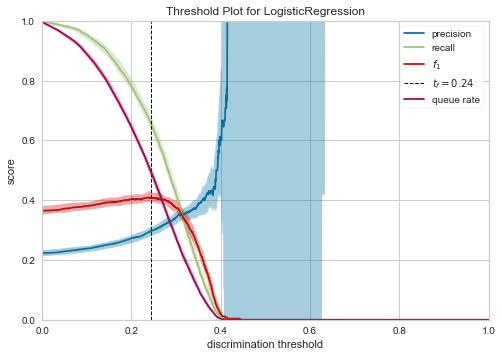

In [35]:
# Get the Optimal threshold via the F1 values

from yellowbrick.classifier.threshold import discrimination_threshold

dt = discrimination_threshold(lr_model, x_train, y_train)

f_idx = dt.cv_scores_["fscore"].argmax()

f_thresh = dt.thresholds_[f_idx]

The discrimination_threshold function plots the F1 score and other metrics and
returns an object with F1 scores along with other metrics. We use this dt object
to retrieve the F1 scores with dt.cv_scores_['fscore'] and get the index of the
maximum value with argmax. This yellowbrick method performs cross-validation on
the provided data to get error bars for the plotted metrics (so it is fitting the model
to the data we provided), and the cv_scores_ attribute is a dictionary holding the
values of the plotted metrics. We provided the x_train and y_train data, meaning
the data in the plot looks a little smoother, since the training data has more data than
the test set. The threshold from this method is 0.223 and we store it in the f_thresh
variable.

> We can see that the plot contains some metrics with the dashed line showing the
ideal threshold based on the F1 score. It contains a `"queue rate"` line, which is simply
the FPR. This is intended to show what percent of samples would benefit from a
review in a business setting. For example, if our procedure is to manually screen any
loan application where our algorithm predicted the customer would default, the FPR
or queue rate can be used to optimize a threshold to meet our review capabilities.
We could take the number of reviews our company can do per week, the number of
applications per week, and combine this with the FPR and TPR to find out what our
threshold should be so we can review all applications with a prediction of a default.
We can access the queue rate values from dt.cv_scores_['queue_rate'].

In [36]:
# Queue Rate

dt.cv_scores_["queue_rate"]

masked_array(data=[0.99777778, 0.99688889, 0.99622222, ..., 0.        ,
                   0.        , 0.        ],
             mask=False,
       fill_value=1e+20)

In [38]:
from sklearn.metrics import accuracy_score

for t in [y_thresh, tl_thresh, f_thresh]:
    print(accuracy_score(y_test, lr_model.predict_proba(x_test)[:, 1] >= t))

0.5864
0.5964
0.5762666666666667


From this, we see that the accuracy for Youden's J, top left, and the F1 methods are
58%, 59%, and 57%. These accuracies are lower than our default threshold of 0.5,
which gave us an accuracy of around 78%. However, these thresholds give us more
true positives on the test set, whereas the 0.5 threshold gave us none. We can plot the
confusion matrix for our Youden's J threshold with mlxtend:

(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

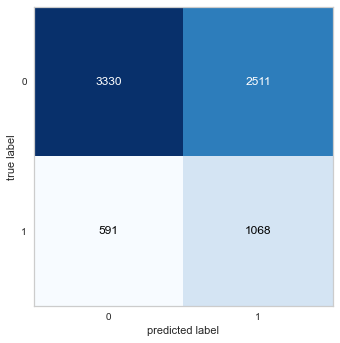

In [45]:
from mlxtend.plotting import plot_confusion_matrix as mlx_plot_cm

from sklearn.metrics import confusion_matrix

predictions = lr_model.predict_proba(x_test)[:, 1] >= y_thresh

mlx_plot_cm(confusion_matrix(y_test, predictions))

We're using mlxtend because the yellowbrick and sklearn plotting functions require
us to provide our model, and don't let us set the rounding threshold for predictions
(they use the 0.5 default). By contrast, the mlxetend version simply takes the
confusion matrix returned from the sklearn.metrics.confusion_matrix function

If you recall from earlier, the confusion matrix with the 0.5 threshold predicted all
test set default values (1s) to be 0s, or non-defaults, and we had 0 true positives in
the bottom right of the confusion matrix. With the lower threshold, we can actually
get some true positives, which could be useful in a business setting.
These optimal threshold methods could also be applied to multi-class, multi-label
classification problems, where we get an optimal threshold for each class. For
a multi-class, single-label problem, we already take the maximum probability from
our predictions as the predicted class and don't need to do threshold optimization.

> With the metrics here, we can compare models and choose the best model
depending on our situation. For example, we may care about precision, recall, or
accuracy the most depending on our application, or we can use the AUC score as
a more general performance metric. Another option would be to combine multiple
metrics into a meta-metric by means of averaging or weighted averaging.

## Sampling and balancing classification data

Sampling data can be used to shrink the data size for code development or to balance
the classes between the dataset. We can also use synthetic sampling techniques,
such as `SMOTE` and `ADASYN`.

### Downsampling

To shrink the size of the dataset while preserving class balance:

In [48]:
_, x_sample, _, y_sample = train_test_split(features, targets, test_size=0.1, stratify = targets, random_state=42)

> The stratify argument is key here so that our targets retain the same balance. Also specify the test_size argument to 0.1, which means that our x_sample and y_sample will have 10% of the original data and set the random_state so our results are reproducible. For sampling down data to a smaller amount for prototyping or developing code, this works great

> Addressing Class Imbalance


In [49]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)

x_resampled, y_resampled = rus.fit_resample(features, targets)

Create a class (with the same random_state argument as in sklearn), and then use methods such as fit. Instead of using fit_transform, as we did in the scalers in sklearn, we use fit_resample
here, providing our features and targets. This returns pandas DataFrames and Series
and works with multi-class as well as single-class targets. Multi-label targets are
not supported currently since it is much more complex to deal with.

In [50]:
y_resampled.value_counts()

0    6636
1    6636
Name: default payment next month, dtype: int64

In [53]:
targets.value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

From our preceding resample, we can verify that the data was resampled with
`y_resampled.value_counts()` and `targets.value_counts()`, which show
that our resampled data has 6,636 of each class, and the y_train data has 6,636 of
the minority class (1). There are other, more complex undersampling techniques in
imblearn described in the documentation that we won't cover here

### Oversampling

Another way to sample data for balancing classes is to use oversampling techniques,
such as bootstrapping (sampling with replacement) to sample existing data so that
the classes become balanced. We will use our same training/test split data as before,
and can perform random bootstrap oversampling with imblearn:

In [56]:
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler


ros = RandomOverSampler(random_state = 0)

x_resampled, y_resampled = ros.fit_resample(x_train, y_train)

lr_model = LogisticRegressionCV(max_iter=1000)

lr_model.fit(x_train, y_train)

print(
    "unmodified:", 
     roc_auc_score(y_test, lr_model.predict_proba(x_test)[:, 1])
     )

lr_model_rs = LogisticRegressionCV(max_iter=1000)

lr_model_rs.fit(x_resampled, y_resampled)

print(
    "resampled:", 
     roc_auc_score(y_test, 
                   lr_model_rs.predict_proba(x_test)[:, 1])
     )

unmodified: 0.6421907492493204
resampled: 0.6537550905712245


This `RandomOverSampler` class bootstraps all minority classes to be up to the same
number of samples as the majority class by default, although this is customizable
with the sampling_strategy argument described in the documentation. We will have
repeats of our data in the dataset, but at least the classes will be balanced. We are
using the CV logistic regression class for our model, which automatically tries 10
different values of C (L2 regularization strength). We then get the AUC score from
the roc_auc_score function of sklearn, which is 0.642 for the unmodified data and
0.654 for the resampled data. It looks like this resampling helped a little bit, but not
significantly.

### SMOTE and other synthetic sampling methods

Bootstrapping improves our models a small amount, but there are other synthetic
sampling techniques that generate new samples based on existing data that can help
too. These interpolate new data based on existing data – essentially, they draw a
line connecting some of the data points and generate some new data along that line.
SMOTE (synthetic minority oversampling technique) is one of the classic methods
but has some problems. It generates samples randomly without consideration for
which samples might be best to generate. Usually, generating new samples in the
feature space where classes are overlapping or nearby is ideal, so that the classifier
can learn to separate the data better.

Another method is ADASYN (adaptive synthetic) sampling, which incorporates
consideration for where new data should be generated. SMOTE also has several
variants that generate samples on the boundaries of classes, and the newest and
potentially best SMOTE variant (at the time of writing) is k-means SMOTE, which
was invented around 2017.

In [57]:
from imblearn.over_sampling import KMeansSMOTE


km_SMOTE = KMeansSMOTE(k_neighbors =5,
                       cluster_balance_threshold=0.2,
                       random_state = 42,
                       n_jobs=-1
                      )

x_resampled, y_resampled = km_SMOTE.fit_resample(x_train, y_train)

lr_model_rs = LogisticRegressionCV(max_iter=1000)

lr_model_rs.fit(x_resampled, y_resampled)

print(
    "resampled:", 
     roc_auc_score(y_test, 
                   lr_model_rs.predict_proba(x_test)[:, 1])
     )

C:\Users\INNO\Anaconda3\envs\practical_data_science_env\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


resampled: 0.6444781072543355


The k-means SMOTE method has some parameters we need to set, such as
cluster_balance_threshold, in order for it to work properly. For our data,
this needs to be a smaller value than the default of 0.1 or 0.2. The k_neighbors
parameter is also adjustable and could be tuned as a hyperparameter in the pipeline
of oversampling and then fitting a model. With this model, we get an AUC score
of 0.643, which is not an improvement beyond random oversampling.

There are several other oversamplers in imblearn, most of them variants of SMOTE.
The imblearn.combine module also contains more oversamplers, which oversample
and then prune the data according to certain algorithms. We can try all these other
oversamplers to see how they affect the AUC score:

In [59]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

from imblearn.combine import SMOTEENN, SMOTETomek

samplers = [
    SMOTE(random_state=42),
    BorderlineSMOTE(random_state=42, kind="borderline-1"),
    BorderlineSMOTE(random_state=42, kind="borderline-2"),
    SVMSMOTE(random_state=42),
    ADASYN(random_state=42),
    SMOTEENN(random_state=42),
    SMOTETomek(random_state=42)
]


for sampler in samplers:
    x_resampled, y_resampled = sampler.fit_resample(x_train, y_train)
    lr_model_rs = LogisticRegressionCV(max_iter=1000)
    lr_model_rs.fit(x_resampled, y_resampled)
    ra_score = roc_auc_score(y_test,
        lr_model_rs.predict_proba(x_test)[:, 1])
    print(f'{str(sampler):<55} {ra_score}')

SMOTE(random_state=42)                                  0.6600452476873847
BorderlineSMOTE(random_state=42)                        0.6596588787105844
BorderlineSMOTE(kind='borderline-2', random_state=42)   0.6544949087321968
SVMSMOTE(random_state=42)                               0.6624967918681715
ADASYN(random_state=42)                                 0.6561024059414963
SMOTEENN(random_state=42)                               0.6541596221922331
SMOTETomek(random_state=42)                             0.6601633048747402


We first import all the other oversamplers and then put them in a list. Next, we loop
through the oversamplers, resampling data, fitting our model, and then printing out
the oversampler and the AUC score. We use f-string formatting so we can left-justify
the oversampler name within a 55-character space with the {str(s):<55} part of the
string. 

From this, we see that the SVMSMOTE method appears to have a slightly higher
AUC score than the rest of the methods, but not by much. In this case, it doesn't hurt
to oversample the data for training as long as it doesn't take too long to run, but it
doesn't help that much either. The improvement here of a few percent with synthetic
oversampling is typical. Most of the time, we can't expect dramatic improvements
with oversampling and should be careful to compare the metrics between models
on the same level. For example, we trained the models on the training split of the
data and evaluated all the models on the unmodified test set. If we were to evaluate
models on the resampling data, for example, we would get much higher accuracies
and AUC scores, but it would not be an accurate representation of the situation.
Although not a magic bullet, oversampling can be helpful in squeezing out some
extra performance from our classifiers.